In [ ]:
import nibabel

def read_exam(exam_nb):
    image_WI = nibabel.load('mri-%02d-WI.nii.gz'%(exam_nb))
    image_AR = nibabel.load('mri-%02d-AR.nii.gz'%(exam_nb))
    image_EV = nibabel.load('mri-%02d-EV.nii.gz'%(exam_nb))
    image_LV = nibabel.load('mri-%02d-LV.nii.gz'%(exam_nb))
    mask = nibabel.load('mri-%02d-mask.nii.gz'%(exam_nb))
    return image_WI, image_AR, image_EV, image_LV, mask

In [ ]:
train_ids, test_id = [1,2,3,4,5,6], 7

Visualisons les données de la base d'apprentissage.

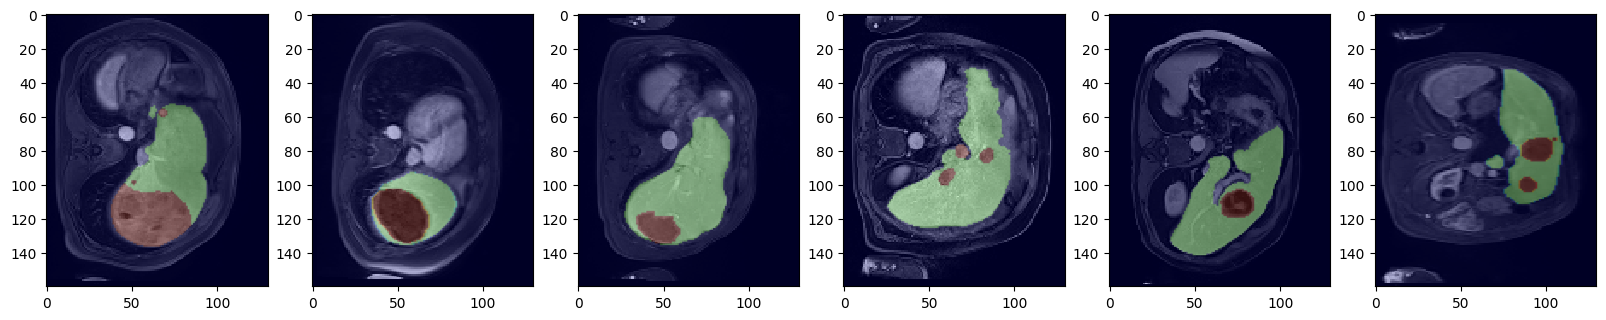

In [ ]:
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

EV_slices, mask_slices = [], []
for train_id in train_ids:
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()==2.)[2])
    z = a[int(2*len(a)/3)]
    EV_slices.append(resize(image_EV.get_fdata()[:,:,z],(160,130),mode='reflect'))
    mask_slices.append(resize(mask.get_fdata()[:,:,z],(160,130),mode='reflect'))

plt.figure(figsize=(20, 15))
for i in range(len(train_ids)):
    plt.subplot(1, len(train_ids), i+1)
    plt.imshow(EV_slices[i], cmap='gray', interpolation='nearest')
    plt.imshow(mask_slices[i], cmap='jet', alpha=0.3)
plt.show()

In [ ]:
slice_ = 27
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
slice_WI = image_WI.get_fdata()[:,:,slice_]
slice_AR = image_AR.get_fdata()[:,:,slice_]
slice_EV = image_EV.get_fdata()[:,:,slice_]
slice_LV = image_LV.get_fdata()[:,:,slice_]
slice_mask = mask.get_fdata()[:,:,slice_] .astype(np.uint8)

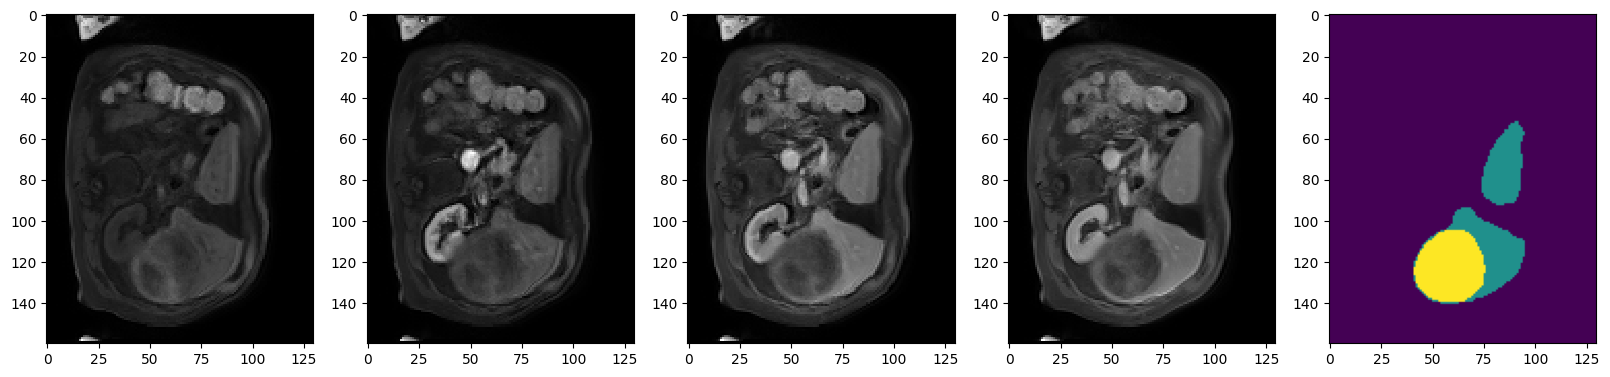

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 5, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 5)
plt.imshow(slice_mask)
plt.show()

In [ ]:
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)

mask_data = mask.get_fdata()
wi_data = image_WI.get_fdata()
ar_data = image_AR.get_fdata()
ev_data = image_EV.get_fdata()
lv_data = image_LV.get_fdata()

# Get the indices for healthy and tumorous regions within the liver mask
healthy_indices = np.where(mask_data == 1)
tumor_indices = np.where(mask_data == 2)

# Calculate the average intensity for each time point
avg_intensity_wi_healthy = np.mean(wi_data[healthy_indices])
avg_intensity_ar_healthy = np.mean(ar_data[healthy_indices])
avg_intensity_ev_healthy = np.mean(ev_data[healthy_indices])
avg_intensity_lv_healthy = np.mean(lv_data[healthy_indices])

avg_intensity_wi_tumor = np.mean(wi_data[tumor_indices])
avg_intensity_ar_tumor = np.mean(ar_data[tumor_indices])
avg_intensity_ev_tumor = np.mean(ev_data[tumor_indices])
avg_intensity_lv_tumor = np.mean(lv_data[tumor_indices])

# Store the average intensities
healthy_intensities = [avg_intensity_wi_healthy, avg_intensity_ar_healthy, avg_intensity_ev_healthy, avg_intensity_lv_healthy]
tumor_intensities = [avg_intensity_wi_tumor, avg_intensity_ar_tumor, avg_intensity_ev_tumor, avg_intensity_lv_tumor]

time_points = ['WI', 'AR', 'EV', 'LV']

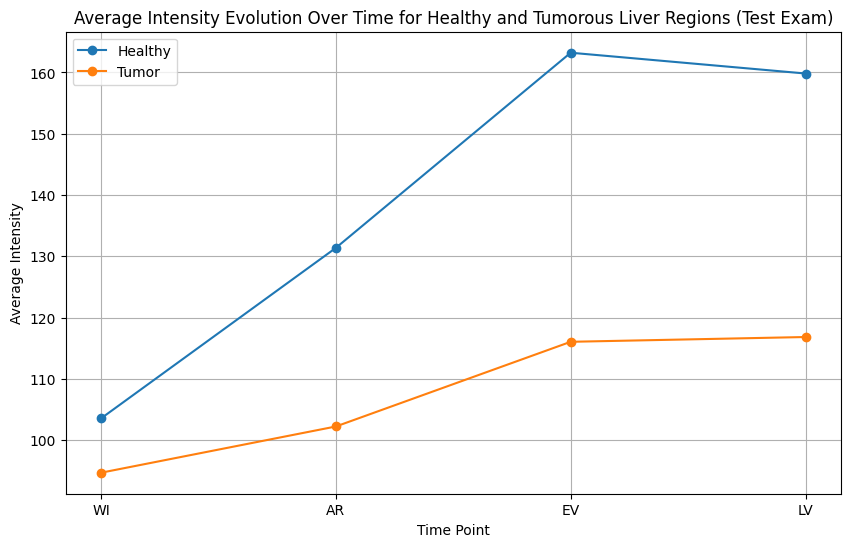

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, healthy_intensities, marker='o', linestyle='-', label='Healthy')
plt.plot(time_points, tumor_intensities, marker='o', linestyle='-', label='Tumor')
plt.xlabel('Time Point')
plt.ylabel('Average Intensity')
plt.title('Average Intensity Evolution Over Time for Healthy and Tumorous Liver Regions (Test Exam)')
plt.legend()
plt.grid(True)
plt.show()

Apprentissage statistique par forêt aléatoire n'exploitant qu'une seule phase

In [ ]:
def exam2vec_mono(image_EV, mask):
    vec_EV = image_EV.get_fdata()[mask.get_fdata() != 0].flatten()
    vec_mask = mask.get_fdata()[mask.get_fdata() != 0].flatten()
    data = vec_EV.reshape(-1, 1)
    return data, vec_mask

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

clf_mono = RandomForestClassifier(n_estimators=15, random_state=0)

all_data = []
all_masks = []

for train_id in train_ids:
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)
    data, vec_mask = exam2vec_mono(image_EV, mask)
    all_data.append(data)
    all_masks.append(vec_mask)

X_train = np.concatenate(all_data)
y_train = np.concatenate(all_masks)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

clf_mono.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=15, random_state=0)

In [ ]:
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
flatten_ = image_EV.get_fdata().flatten()
est_image = flatten_.reshape(-1,1)

data_test, vec_mask_test = exam2vec_mono(image_EV, mask)

X_test_scaled = scaler.transform(data_test)

y_pred_test = clf_mono.predict(X_test_scaled)

# Reshape the prediction back to the original mask shape
seg_mono = np.zeros_like(mask.get_fdata())
seg_mono[mask.get_fdata() != 0] = y_pred_test

In [ ]:
slice_seg_mono = seg_mono[:,:,slice_].astype(np.uint8)

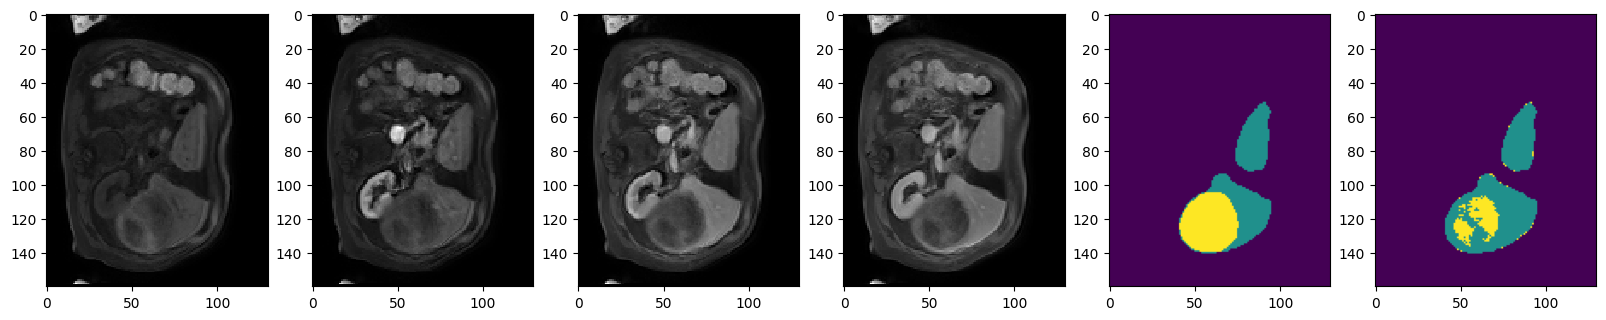

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 6, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 5)
plt.imshow(slice_mask)
plt.subplot(1, 6, 6)
plt.imshow(slice_seg_mono)
plt.show()

In [ ]:
def compute_dice(res, gt, domain, label):
    """Compute the Dice coefficient (%) for a given label within a specified domain.

    Args:
        res (ndarray): Predicted segmentation.
        gt (ndarray): Ground truth segmentation.
        domain (ndarray): Binary mask defining the region of interest.
        label (int or float): Label value to evaluate.

    Returns:
        float: Dice coefficient (in %).
    """
    A = (gt == label)
    B = (res == label)
    C = (domain != 0)

    TP = np.count_nonzero(A & B & C)
    FN = np.count_nonzero(A & ~B & C)
    FP = np.count_nonzero(~A & B & C)

    denominator = FP + 2 * TP + FN
    if denominator == 0:
        return 0.0

    dice = 2 * TP / denominator
    return dice * 100

In [ ]:
# tissus hépatiques sains
healthy_dice_mono = compute_dice (seg_mono, mask.get_fdata(), mask.get_fdata(), 1)
print('dice (tissus sains) :', healthy_dice_mono)
# tissus hépatiques tumoraux
tumor_dice_mono = compute_dice (seg_mono, mask.get_fdata(), mask.get_fdata(), 2)
print('dice (tissus tumoraux) :', tumor_dice_mono)

dice (tissus sains) : 78.4423508901331
dice (tissus tumoraux) : 46.113555415880995


Apprentissage statistique multi-phase

In [ ]:
def exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask):
    vec_WI = image_WI.get_fdata()[mask.get_fdata() != 0].flatten()
    vec_AR = image_AR.get_fdata()[mask.get_fdata() != 0].flatten()
    vec_EV = image_EV.get_fdata()[mask.get_fdata() != 0].flatten()
    vec_LV = image_LV.get_fdata()[mask.get_fdata() != 0].flatten()
    vec_mask = mask.get_fdata()[mask.get_fdata() != 0].flatten()
    data = np.column_stack((vec_WI,vec_AR,vec_EV,vec_LV))
    return data, vec_mask

In [ ]:

clf_multi = RandomForestClassifier(n_estimators=15, random_state=0)

all_data_multi = []
all_masks_multi = []

for train_id in train_ids:
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)
    data_multi, vec_mask_multi = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)
    all_data_multi.append(data_multi)
    all_masks_multi.append(vec_mask_multi)

X_train_multi = np.concatenate(all_data_multi)
y_train_multi = np.concatenate(all_masks_multi)

scaler_multi = StandardScaler()
X_train_scaled_multi = scaler_multi.fit_transform(X_train_multi)

clf_multi.fit(X_train_scaled_multi, y_train_multi)

RandomForestClassifier(n_estimators=15, random_state=0)

In [ ]:
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)

data_test_multi, vec_mask_test_multi = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)

X_test_scaled_multi = scaler_multi.transform(data_test_multi)

y_pred_test_multi = clf_multi.predict(X_test_scaled_multi)

# Reshape the prediction back to the original mask shape
seg_multi = np.zeros_like(mask.get_fdata())
seg_multi[mask.get_fdata() != 0] = y_pred_test_multi

In [ ]:
slice_seg_multi = seg_multi[:,:,slice_].astype(np.uint8)

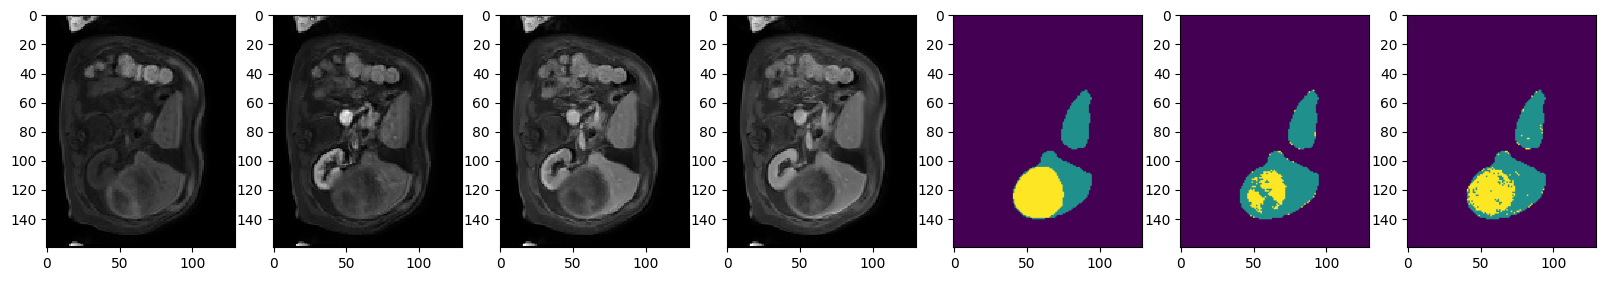

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 7, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 5)
plt.imshow(slice_mask)
plt.subplot(1, 7, 6)
plt.imshow(slice_seg_mono)
plt.subplot(1, 7, 7)
plt.imshow(slice_seg_multi)
plt.show()

In [ ]:
healthy_dice_multi = compute_dice (seg_multi, mask.get_fdata(), mask.get_fdata(), 1)
print("mono phase :", healthy_dice_mono, "multi phases : ",healthy_dice_multi)

mono phase : 78.4423508901331 multi phases :  84.04070807829605


In [ ]:
tumor_dice_multi = compute_dice (seg_multi, mask.get_fdata(), mask.get_fdata(), 2)
print("mono phase :",tumor_dice_mono, "multi phases : ",tumor_dice_multi)

mono phase : 46.113555415880995 multi phases :  70.05011452287874


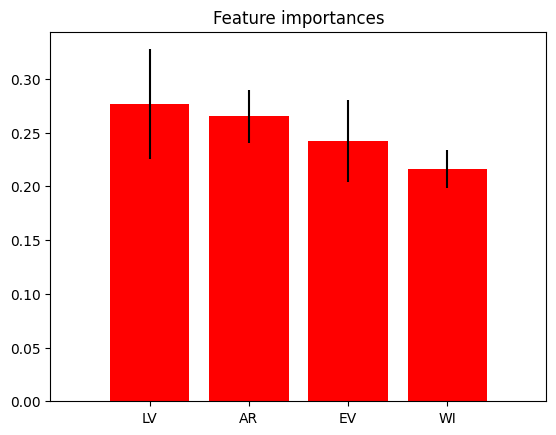

In [ ]:
importances = clf_multi.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_multi.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
labels = ['WI', 'AR', 'EV', 'LV']
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_multi.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_multi.shape[1]), [labels[i] for i in indices]) # Use labels for x-axis
plt.xlim([-1, X_train_multi.shape[1]])
plt.show()

Ajout d'un pré-traitement

In [ ]:
from skimage.restoration import denoise_tv_bregman

def filter_exam_bregman(image_WI,image_AR,image_EV,image_LV,weight=0.1):
    image_WI.get_fdata()[:] = denoise_tv_bregman(image_WI.get_fdata(), weight=weight)
    image_AR.get_fdata()[:] = denoise_tv_bregman(image_AR.get_fdata(), weight=weight)
    image_EV.get_fdata()[:] = denoise_tv_bregman(image_EV.get_fdata(), weight=weight)
    image_LV.get_fdata()[:] = denoise_tv_bregman(image_LV.get_fdata(), weight=weight)

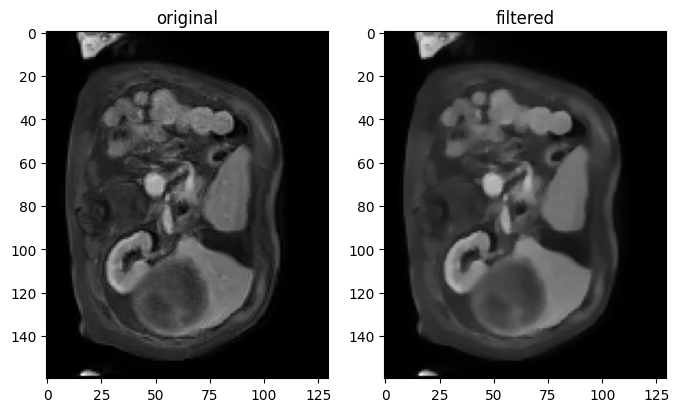

In [ ]:

image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
original_EV_slice = image_EV.get_fdata()[:,:,slice_]
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].set_title("original")
ax[0].imshow(original_EV_slice, cmap='gray')
filter_exam_bregman(image_WI, image_AR, image_EV, image_LV)
slice_EV_filter = image_EV.get_fdata()[:,:,slice_]
ax[1].set_title("filtered")
ax[1].imshow(slice_EV_filter, cmap='gray')

In [ ]:
clf_filter = RandomForestClassifier(n_estimators=15, random_state=0)

all_data_filter = []
all_masks_filter = []

for train_id in train_ids:
    # Read the exam
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)

    # Apply filtering
    # Note: filter_exam_bregman modifies the image objects in place
    filter_exam_bregman(image_WI, image_AR, image_EV, image_LV, weight=5) # Using weight=5 as previously discussed

    # Extract data and mask for training
    data_filter, vec_mask_filter = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)

    all_data_filter.append(data_filter)
    all_masks_filter.append(vec_mask_filter)

X_train_filter = np.concatenate(all_data_filter)
y_train_filter = np.concatenate(all_masks_filter)

scaler_filter = StandardScaler()
X_train_scaled_filter = scaler_filter.fit_transform(X_train_filter)

clf_filter.fit(X_train_scaled_filter, y_train_filter)

RandomForestClassifier(n_estimators=15, random_state=0)

In [ ]:
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)

# Apply filtering to the test exam images
filter_exam_bregman(image_WI, image_AR, image_EV, image_LV, weight=5) # Use the same weight as training

data_test_filter, vec_mask_test_filter = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)

X_test_scaled_filter = scaler_filter.transform(data_test_filter)

y_pred_test_filter = clf_filter.predict(X_test_scaled_filter)

# Reshape the prediction back to the original mask shape
seg_filter = np.zeros_like(mask.get_fdata())
seg_filter[mask.get_fdata() != 0] = y_pred_test_filter

In [ ]:
slice_seg_filter = seg_filter[:,:,slice_].astype(np.uint8)

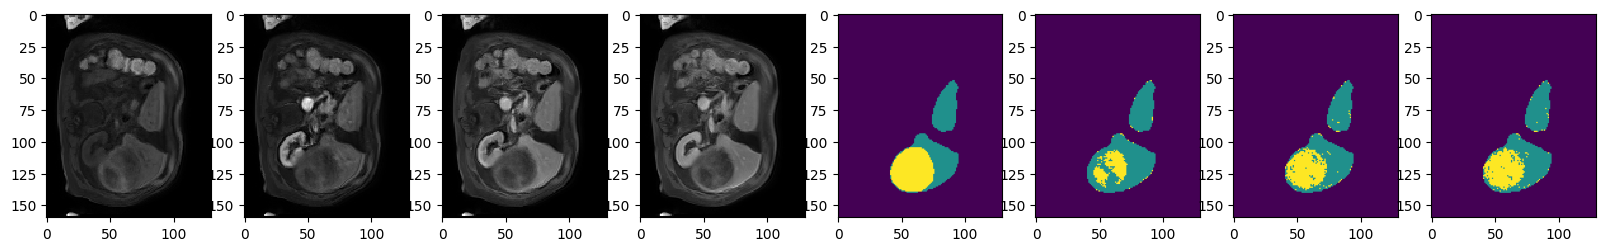

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 8, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 5)
plt.imshow(slice_mask)
plt.subplot(1, 8, 6)
plt.imshow(slice_seg_mono)
plt.subplot(1, 8, 7)
plt.imshow(slice_seg_multi)
plt.subplot(1, 8, 8)
plt.imshow(slice_seg_filter)
plt.show()

In [ ]:
healthy_dice_filter = compute_dice (seg_filter, mask.get_fdata(), mask.get_fdata(), 1)
print(healthy_dice_mono, healthy_dice_multi, healthy_dice_filter)

78.4423508901331 84.04070807829605 84.23665170803187


In [ ]:
tumor_dice_filter = compute_dice (seg_filter, mask.get_fdata(), mask.get_fdata(), 2)
print(tumor_dice_mono, tumor_dice_multi, tumor_dice_filter)

46.113555415880995 70.05011452287874 70.24616235652054
